In [1]:
import torch 
import torch.nn as nn
from torch import Tensor
from torch.utils.data import DataLoader
import numpy as np
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import sys
from typing import Tuple
from scipy.signal import convolve2d
from tqdm.auto import tqdm

sys.path.insert(0, '../')

from src.datasets import Distograms
from src.lit_models import DCGAN

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
# mask data

dataset = Distograms('../data/training_30_64.hdf5', 100)
loader = DataLoader(dataset, batch_size=1, shuffle=True)

In [48]:
batch = next(iter(loader))

In [49]:
batch.shape

torch.Size([1, 1, 64, 64])

In [50]:
batch = batch.squeeze(0)

In [51]:
def add_random_mask(distogram: Tensor, span: int) -> Tuple[Tensor, Tensor]:
    
    """Mask contiguous region with zeros
    
    Args:
        distogram: Input distogram with shape [channel (1), height, width]
        span: Number of missing residues
        
    Returns:
        disto_masked: Corrupted distogram
        mask: Hole mask indicating zeroed region for inpainting
    """
    
    # randomly select region
    start_idx = np.random.randint(0, distogram.shape[1]-span)
    end_idx = start_idx + span
    
    # mask where 0=hole
    mask = np.ones((distogram.shape[1], distogram.shape[2]))
    mask[start_idx:end_idx, :] = 0.
    mask[:,start_idx:end_idx] = 0.
    
    # zero out on disto
    disto_masked = distogram.squeeze(0) * mask
    
    # add batch dim back
    disto_masked = disto_masked.unsqueeze(0)
    mask = torch.tensor(mask).unsqueeze(0)
    
    return disto_masked, mask
    

In [52]:
def weight_mask(mask: Tensor, filter_size: int) -> Tensor:
    
    """Weight pixels at boundary of masked region for context loss
    
    Args:
        mask: Binary mask where 0=hole, shape [channels (1), height, width]
        filter_size: Identity filter size
        
    Returns:
        w_mask: Importance weighting term
    """
    
    mask = mask.detach().cpu().numpy()
    
    ker = np.ones((filter_size, filter_size))
    ker = ker / ker.sum()
    mask_comp = (1 - mask).squeeze(0)
    
    w_mask = mask * convolve2d(mask_comp, ker, mode='same', boundary='symm')
    
    return torch.tensor(w_mask, device=device)

In [53]:
disto_masked, mask = add_random_mask(batch, 10)
w_mask = weight_mask(mask, 12)

In [54]:
def plot_tensor(tensor: Tensor, ax=None) -> None:
    
    """Convert tensor to arr and plot
    
    Args:
        tensor: Single input to plot [channels (1), height, width]
        ax: Subplot axis
    """
    
    if ax is None:
        ax = plt.gca()
        
    arr = tensor.view(64, 64).detach().cpu().numpy()
    ax.imshow(arr)
    ax.axis('off')

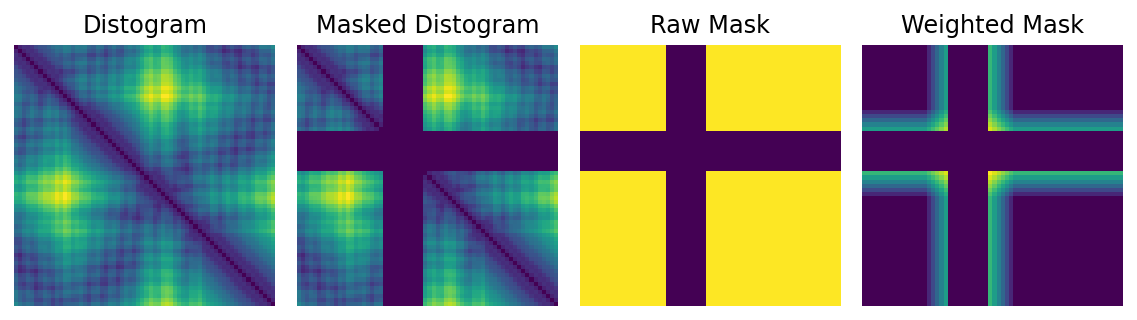

In [55]:
fig, ax = plt.subplots(1, 4, figsize=(8, 4))

plot_tensor(batch, ax[0])
plot_tensor(disto_masked, ax[1])
plot_tensor(mask, ax[2])
plot_tensor(w_mask, ax[3])

ax[0].set_title('Distogram')
ax[1].set_title('Masked Distogram')
ax[2].set_title('Raw Mask')
ax[3].set_title('Weighted Mask')

plt.tight_layout()

In [35]:
class SemanticInpainter:
    
    """Run semantic inpainting
    
    Args:
        dcgan_path: Path to trained dcgan model
        lamda: Scaling factor for prior loss
        beta1: Adam beta1
        beta2: Adam beta2
        lr: Learning rate
        steps: Number of steps to optimize z
        gamma: Learning rate decay factor
        step_size: Steps between lr decay
        filter_size: Weighted mask filter size
    """
    
    def __init__(self, 
                 dcgan_path: str, 
                 lamda: float = 0.003, 
                 beta1: float = 0.5, 
                 beta2: float = 0.999,
                 lr: float = 1e-1, 
                 steps: int = 2_000, 
                 gamma: float = 0.05, 
                 step_size: int = 10,
                 filter_size: int = 9):
        
        # load trained dcgan
        self.model = DCGAN.load_from_checkpoint(dcgan_path).to(device)
        
        self.lamda = lamda
        self.beta1 = beta1
        self.beta2 = beta2
        self.lr = lr
        self.steps = steps
        self.gamma = gamma
        self.step_size = step_size
        self.filter_size = filter_size
        
    def inpaint(self, disto_masked: Tensor, mask: Tensor) -> Tuple[Tensor, Tensor]:
        
        disto_masked = disto_masked.to(device)
        mask = mask.to(device)
        
        # optimize random z
        z_opt = torch.randn(1, 100, 1, 1, requires_grad=True, device=device)
        optimizer = torch.optim.Adam([z_opt], lr=self.lr, betas=(self.beta1, self.beta2))
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=self.step_size, gamma=self.gamma)
        
        for step in tqdm(range(self.steps)):
            optimizer.zero_grad()
            
            # fake image to overlay on masked region
            g_z = self.model(z_opt)
            
            # l1 reconstruction with higher weight on pixels at boundary
            w_mask = weight_mask(mask, self.filter_size)
            loss_context = torch.sum(w_mask * torch.abs((g_z - disto_masked)))
            #loss_context = torch.mean(mask*torch.abs(g_z-disto_masked))
            
            # generator loss on fake image
            d_g_z = torch.sigmoid(self.model.discriminator(g_z))
            loss_prior = torch.mean(torch.log(1 - d_g_z))
            
            # discriminator loss on final inpainted
            inpainted = ((1-mask)*g_z + disto_masked).float()
            loss_disc = torch.mean(torch.log(1 - torch.sigmoid(self.model.discriminator(inpainted))))
            
            total_loss = loss_context + self.lamda*loss_prior + loss_disc
            total_loss.backward()
            
            nn.utils.clip_grad_norm_([z_opt], max_norm=2.0, norm_type=2)
            optimizer.step()
            scheduler.step()
            
#             if step % 20 == 0:
#                 print(loss_context.item(), loss_prior.item(), loss_disc.item())
#                 plot_tensor(g_z)
#                 plt.show()
            
        return inpainted, g_z

In [56]:
CHECKPOINT = '../outputs/2022-06-03/22-17-23/lightning_logs/version_0/checkpoints/epoch=99-step=37599.ckpt'

In [73]:
si = SemanticInpainter(CHECKPOINT, steps=3_000)

In [74]:
inpainted, g_z = si.inpaint(disto_masked, mask)

  0%|          | 0/3000 [00:00<?, ?it/s]

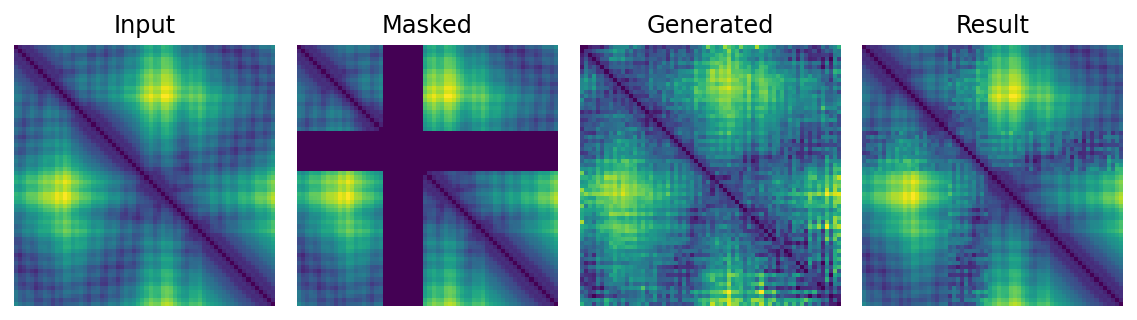

In [75]:
fig, ax = plt.subplots(1, 4, figsize=(8, 4))

plot_tensor(batch, ax[0])
plot_tensor(disto_masked, ax[1])
plot_tensor(g_z, ax[2])
plot_tensor(inpainted, ax[3])

ax[0].set_title('Input')
ax[1].set_title('Masked')
ax[2].set_title('Generated')
ax[3].set_title('Result')

plt.tight_layout()

# generator needs longer training